In [19]:
# 0 Housekeeping. Clear variable space
######################################
from IPython import get_ipython  

ipython = get_ipython()
ipython.magic("reset -f")
ipython = get_ipython()
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import folium
from folium.plugins import MarkerCluster
from folium import CircleMarker
from IPython.display import IFrame
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# 1 Import Libraries and Set Global Parameters
##############################################
# 1.1 Import Python Libraries
#############################
from datetime import datetime
print("Run Section 1 Import Libraries and Set Global Parameters...")
begin_time = datetime.now()

import os, sys
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq

Run Section 1 Import Libraries and Set Global Parameters...


In [22]:
# 1.2 Set Global Parameters
###########################
    
if os.getlogin() == "E048374":
    # Working Paths
    path_working = r"C:\Users\E048374\OneDrive - WMATA\rawnav_rachel_fork\WMATA_AVL"
    os.chdir(os.path.join(path_working))
    sys.path.append(r"C:\Users\E048374\OneDrive - WMATA\rawnav_rachel_fork\WMATA_AVL")
    path_source_data = r"\\l-600730\RawNavArchive"
    path_sp = r"C:\Users\E048374\Documents\RawNav"
    path_processed_data = os.path.join(path_working, "data", "02-processed")
    path_segments = os.path.join(path_working, "data", "02-processed")

else:
    raise FileNotFoundError("Define the path_working, path_source_data, gtfs_dir, \
                            ZippedFilesloc, and path_processed_data in a new elif block")

In [23]:
# Globals
# Queue Jump Routes
q_jump_route_list = ['52']
analysis_routes = q_jump_route_list
# EPSG code for WMATA-area work
wmata_crs = 2248
     
# 1.3 Import User-Defined Package
#################################
import wmatarawnav as wr

In [24]:
seg_pattern = pd.read_csv(os.path.join(path_segments,"stop_seq_pattern_5201_by_intersection.csv"),
                         dtype={'route':str, 'PATTERN_ID':str, 'pattern':'int32'})
seg_pattern

,seg_name_id,geoid,stop_id,route,pattern
0,14th_12,16203,21627,52,1
1,14th_14,16662,19066,52,1
2,14th_17,0,0,52,1
3,14th_21,0,0,52,1
4,14th_22,0,0,52,1
5,14th_24,0,0,52,1
6,14th_25,7243,19143,52,1


In [25]:
xwalk_seg_pattern_stop = seg_pattern[['route','pattern','seg_name_id','stop_id']].copy()
xwalk_seg_pattern_stop

,route,pattern,seg_name_id,stop_id
0,52,1,14th_12,21627
1,52,1,14th_14,19066
2,52,1,14th_17,0
3,52,1,14th_21,0
4,52,1,14th_22,0
5,52,1,14th_24,0
6,52,1,14th_25,19143


In [26]:
rawnav_dat = (
        wr.read_cleaned_rawnav(
           analysis_routes_ = analysis_routes,
           path = os.path.join(path_processed_data, "rawnav_summary.parquet")
        )
    )

In [27]:
segment_summary = (
        pq.read_table(
            source = os.path.join(path_processed_data,"segment_summary.parquet"),
            filters = [['seg_name_id', "=", '14th_14']],
            use_pandas_metadata = True
        )
        .to_pandas()
    )

In [29]:
segment_decomp_df = pd.DataFrame()
for seg in list(xwalk_seg_pattern_stop.seg_name_id.drop_duplicates()[:]):
    print(f"working on segment: {seg}")
    xwalk_seg_pattern_stop_fil = xwalk_seg_pattern_stop.query('seg_name_id == @seg')

    # xwalk_seg_pattern_stop_fil['stop_id'].values[0]==0

    seg_routes = list(xwalk_seg_pattern_stop_fil.route.drop_duplicates())

    rawnav_dat = (
        wr.read_cleaned_rawnav(
           analysis_routes_ = seg_routes,
           path = os.path.join(path_processed_data, "rawnav_data.parquet")
        )
        .drop(columns=['blank', 'lat_raw', 'long_raw', 'sat_cnt'])
    )

    segment_summary = (
        pq.read_table(
            source = os.path.join(path_processed_data,"segment_summary.parquet"),
            filters = [['seg_name_id', "=", seg]],
            use_pandas_metadata = True
        )
        .to_pandas()
    )
    
    
    #removed | flag_wrong_order_any\
    segment_summary_fil = (
        segment_summary
        .query('~(flag_too_far_any\
                  | flag_too_long_odom\
                  | flag_secs_total_mismatch\
                  | flag_odom_total_mismatch)'
        )
    )
    
    if xwalk_seg_pattern_stop_fil['stop_id'].values[0]==0:
        print("xwalk_seg_pattern_stop_fil['stop_id'].values[0]==0")
    
        rawnav_filtered = wr.filter_to_segment(rawnav_dat,
                                         segment_summary_fil)

        freeflow_seg = wr.decompose_segment_ff(rawnav_dat, segment_summary_fil)
        segment_ff_val = (
            freeflow_seg
            .loc[0.95]
            .loc["fps_next3"]
        )

        rawnav_fil_seg = wr.calc_rolling_vals(rawnav_filtered)


        totals = (
            rawnav_fil_seg
            .groupby(['filename','index_run_start'])
            .agg({"odom_ft": [lambda x: max(x) - min(x)],
                  "sec_past_st" : [lambda x: max(x) - min(x)],
                 "fps_next3": [lambda x: np.mean(x)]})
            .pipe(wr.reset_col_names)
            .rename(columns = {'odom_ft_<lambda>': 'odom_ft_seg_total',
                               'sec_past_st_<lambda>':'t_segment',
                              'fps_next3_<lambda>':'avg_fps'})
        )

        totals.loc[:,'ff_fps'] = segment_ff_val
        totals.loc[:,'t_ff'] = totals.loc[:,['ff_fps','odom_ft_seg_total']].apply(lambda x: 
                                                                                  x['odom_ft_seg_total']/x['ff_fps']
                                                                            ,axis=1)
        totals.loc[:,'t_traffic'] = totals.loc[:,['t_ff','t_segment']].apply(lambda x: 
                                                                             0 if x['t_segment']-x['t_ff']<0
                                                                             else x['t_segment']-x['t_ff']
                                                                            ,axis=1)

        totals.loc[:,'seg_name_id'] = seg
        totals.loc[:,'t_stop'] = 0
        totals.loc[:,'t_stop1'] = 0
        totals.loc[:,'t_stop2'] = 0
        
        

        segment_part = (totals[['filename', 'index_run_start', 'odom_ft_seg_total', 't_segment',
                       't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']].merge(
                segment_summary_fil[['filename', 'index_run_start','start_date_time']],
                how='left',on=['filename', 'index_run_start'])
                                )[['filename', 'index_run_start','start_date_time', 'odom_ft_seg_total', 't_segment',
                       't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']]
        
        if segment_decomp_df.empty:
            segment_decomp_df = segment_part
        else:
            segment_decomp_df = segment_decomp_df.append(segment_part)
            
    else:
        print("xwalk_seg_pattern_stop_fil['stop_id'].values[0]!=0")
        freeflow_list = []
        stop_area_decomp_list = []
        traveltime_decomp_list = []
        stop_index = ( pq.read_table(source=os.path.join(path_processed_data,"stop_index.parquet"),
                      filters=[[('route','=',route)] for route in seg_routes],
                        columns = [ 'route',
                                    'pattern',
                                    'stop_id',
                                    'filename',
                                    'index_run_start',
                                    'index_loc',
                                    'odom_ft',
                                    'sec_past_st',
                                    'geo_description'],
                      use_pandas_metadata = True
        ).to_pandas()
            # As a bit of proofing, we confirm this is int32 and not string, may remove later
            .assign(pattern = lambda x: x.pattern.astype('int32'))
            .assign(route = lambda x: x.route.astype(str))
            .rename(columns = {'odom_ft' : 'odom_ft_qj_stop'})
        )

        stop_index_fil = (
                stop_index
                .merge(xwalk_seg_pattern_stop_fil,
                       on = ['route','pattern','stop_id'],
                       how = 'inner')   
            )
    
            # Calculate Free Flow Travel Time through Entire Segment
        segment_ff = (
            wr.decompose_segment_ff(
                rawnav_dat,
                segment_summary_fil,
                max_fps = 73.3
            )
            .assign(seg_name_id = seg)
        )

        freeflow_list.append(segment_ff)

        # Calculate Stop-Area Decomposition
        stop_area_decomp = (
            wr.decompose_stop_area(
                rawnav_dat,
                segment_summary_fil,
                stop_index_fil
            )
            .assign(seg_name_id = seg)
        )

        stop_area_decomp_list.append(stop_area_decomp)
        
        if stop_area_decomp.stop_area_phase.isin(["t_stop1","t_stop"]).any():
            
            print("['t_stop1','t_stop','t_l_initial','t_l_addl'] in decomp")

            segment_ff_val = (
                segment_ff
                .loc[0.95]
                .loc["fps_next3"]
            )

            # Run decomposition
            traveltime_decomp = (
                wr.decompose_traveltime(
                    rawnav_dat,
                    segment_summary_fil,
                    stop_area_decomp,
                    segment_ff_val
                )
            )
            traveltime_decomp_list.append(traveltime_decomp)

            freeflow = (
                pd.concat(freeflow_list)
                .rename_axis('ntile')
                .reset_index()
            )

            basic_decomp = (
                pd.concat(stop_area_decomp_list)
                .reset_index() 
            )

            traveltime_decomp = (
                pd.concat(traveltime_decomp_list)
                .reset_index()
            )
            
            traveltime_decomp.loc[:,'t_traffic'] = traveltime_decomp.loc[:,'t_traffic'].apply(lambda x: 0 if x<0 else x)
            
            traveltime_decomp_dedupe = traveltime_decomp.drop_duplicates(keep='first')
            segment_part = (traveltime_decomp_dedupe[['filename', 'index_run_start', 'odom_ft_seg_total', 't_segment',
           't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']]
                            .merge(
                                segment_summary_fil[['filename', 'index_run_start','start_date_time']],
                            how='left'
                            ,on=['filename', 'index_run_start'])[['filename', 'index_run_start','start_date_time', 'odom_ft_seg_total', 't_segment',
                       't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']])
            
            if segment_decomp_df.empty:
                segment_decomp_df = segment_part
            else:
                segment_decomp_df = segment_decomp_df.append(segment_part)
            
            
        else:
            print("['t_stop1','t_stop','t_l_initial','t_l_addl'] not in decomp")
            freeflow_seg = wr.decompose_segment_ff(rawnav_dat, segment_summary_fil)
            segment_ff_val = (
                freeflow_seg
                .loc[0.95]
                .loc["fps_next3"]
            )
            
            rawnav_fil_seg = wr.calc_rolling_vals(rawnav_dat)

            rawnav_fil_seg = wr.filter_to_segment(rawnav_fil_seg,
                                               segment_summary_fil)

            totals = (
                rawnav_fil_seg
                .groupby(['filename','index_run_start'])
                .agg({"odom_ft": [lambda x: max(x) - min(x)],
                      "sec_past_st" : [lambda x: max(x) - min(x)],
                     "fps_next3": [lambda x: np.mean(x)]})
                .pipe(wr.reset_col_names)
                .rename(columns = {'odom_ft_<lambda>': 'odom_ft_seg_total',
                                   'sec_past_st_<lambda>':'t_segment',
                                  'fps_next3_<lambda>':'avg_fps'})
            )

            totals.loc[:,'ff_fps'] = segment_ff_val
            totals.loc[:,'t_ff'] = totals.loc[:,['ff_fps','odom_ft_seg_total']].apply(lambda x: 
                                                                                      x['odom_ft_seg_total']/x['ff_fps']
                                                                                ,axis=1)
            totals.loc[:,'t_traffic'] = totals.loc[:,['t_ff','t_segment']].apply(lambda x: 
                                                                                 0 if x['t_segment']-x['t_ff']<0
                                                                                 else x['t_segment']-x['t_ff']
                                                                                ,axis=1)

            totals.loc[:,'seg_name_id'] = seg
            totals.loc[:,'t_stop'] = 0
            totals.loc[:,'t_stop1'] = 0
            totals.loc[:,'t_stop2'] = 0

            segment_part = (totals[['filename', 'index_run_start', 'odom_ft_seg_total', 't_segment',
                       't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']].merge(
                segment_summary_fil[['filename', 'index_run_start','start_date_time']],
                how='left',on=['filename', 'index_run_start'])
                                )[['filename', 'index_run_start','start_date_time', 'odom_ft_seg_total', 't_segment',
                       't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']]
        
            if segment_decomp_df.empty:
                segment_decomp_df = segment_part
            else:
                segment_decomp_df = segment_decomp_df.append(segment_part)

working on segment: 14th_12
xwalk_seg_pattern_stop_fil['stop_id'].values[0]!=0
['t_stop1','t_stop','t_l_initial','t_l_addl'] in decomp
working on segment: 14th_14
xwalk_seg_pattern_stop_fil['stop_id'].values[0]!=0
['t_stop1','t_stop','t_l_initial','t_l_addl'] in decomp
working on segment: 14th_17
xwalk_seg_pattern_stop_fil['stop_id'].values[0]==0
working on segment: 14th_21
xwalk_seg_pattern_stop_fil['stop_id'].values[0]==0
working on segment: 14th_22
xwalk_seg_pattern_stop_fil['stop_id'].values[0]==0
working on segment: 14th_24
xwalk_seg_pattern_stop_fil['stop_id'].values[0]==0
working on segment: 14th_25
xwalk_seg_pattern_stop_fil['stop_id'].values[0]!=0
['t_stop1','t_stop','t_l_initial','t_l_addl'] in decomp


In [30]:
segment_decomp_df.seg_name_id.unique()

array(['14th_12', '14th_14', '14th_17', '14th_21', '14th_22', '14th_24',
       '14th_25'], dtype=object)

In [31]:
agg_all_segments = (segment_decomp_df
    .groupby(['filename','index_run_start'])
     .agg({'t_traffic':sum,
          't_ff':sum,
          't_stop':sum,
          't_stop1':sum,
          't_stop2':sum})
     .reset_index()

)

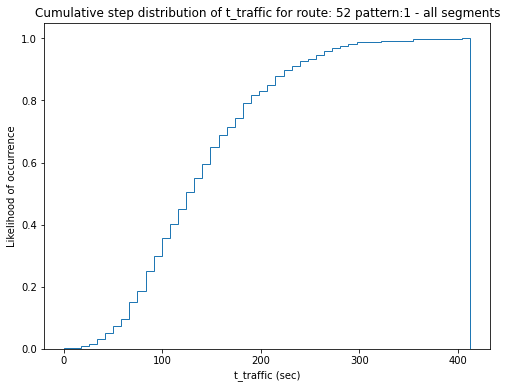

In [32]:
#hacky for now
route = seg_pattern.route.unique()[0]
pattern = seg_pattern.pattern.unique()[0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(agg_all_segments.loc[:,'t_traffic'].values, bins=50, density=True, cumulative=True, histtype='step')
ax.set_title(f'Cumulative step distribution of t_traffic for route: {route} pattern:{pattern} - all segments')
ax.set_xlabel('t_traffic (sec)')
_=ax.set_ylabel('Likelihood of occurrence')

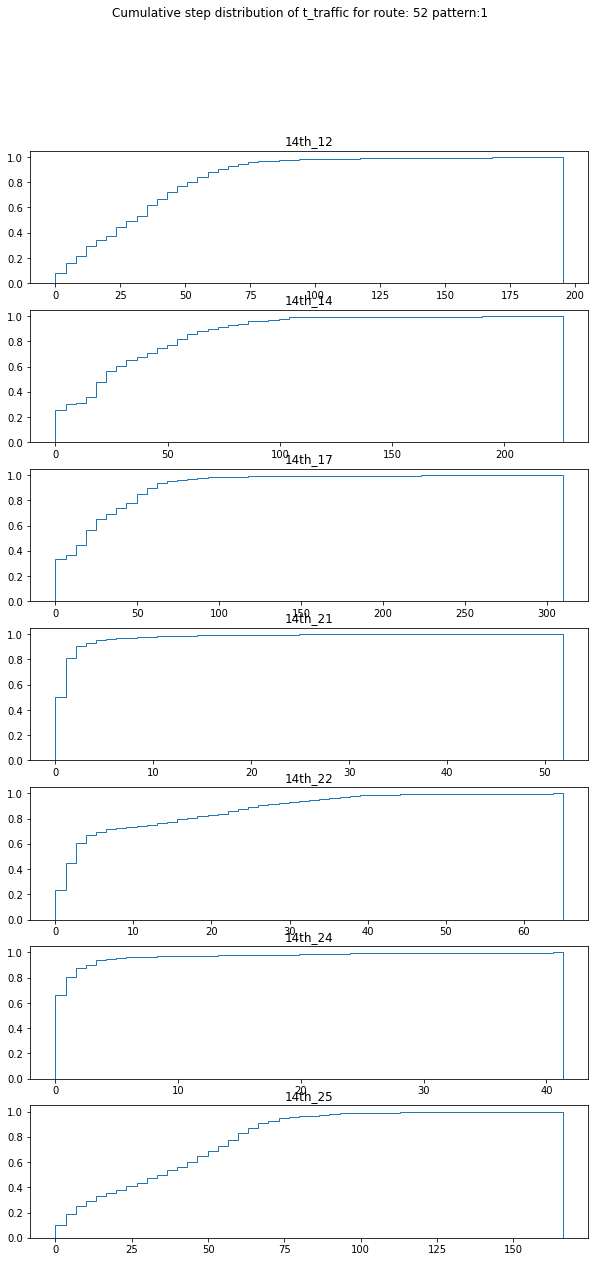

In [33]:
fig, axs = plt.subplots(len(segment_decomp_df.seg_name_id.unique()), sharey=True, figsize=(10,20))
route = seg_pattern.route.unique()[0]
pattern = seg_pattern.pattern.unique()[0]
fig.suptitle(f'Cumulative step distribution of t_traffic for route: {route} pattern:{pattern}')
for idx,seg in enumerate(segment_decomp_df.seg_name_id.unique()):
    segment_decomp_one_seg = segment_decomp_df[segment_decomp_df.loc[:,'seg_name_id']==seg].copy()
    axs[idx].hist(segment_decomp_one_seg.loc[:,'t_traffic'].values, bins=50
                  , density=True, cumulative=True, histtype='step')
    axs[idx].set_title(f'{seg}')

In [34]:
segment_decomp_df.to_csv(os.path.join(path_processed_data, f"segment_decomp_{route+str(pattern).zfill(2)}_201911_14th_buslane.csv"), index=False)